# Import

In [27]:
import torch
import torch.nn as nn
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0')

# Load data

In [4]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2021-10-27 12:51:43--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar’

universum_compresse 100%[===================>]  68.69M   533KB/s    in 6m 24s  

2021-10-27 12:58:07 (183 KB/s) - ‘universum_compressed.tar’ saved [72028160/72028160]



# Preprocessing

In [5]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

In [6]:
transform_all = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)

In [7]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 711.93it/s]


# Model

In [8]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            nn.Conv2d(1, 64, (3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, (3, 3), padding=1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, (3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, (3, 3), padding=1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, (3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, (3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 128, (3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, (3, 3), padding=1),
            nn.ReLU(),
        )
         
        self.postconcat = nn.Sequential(         
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [11]:
def to_numpy_image(img):
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

In [12]:
def plot(x, y):
    img_gray, img_true = x, y
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    plt.figure(figsize=(10,10))
    
    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    
    plt.show()

# Train model

In [16]:
num_epochs = 100
lr = 1e-3

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.SmoothL1Loss()

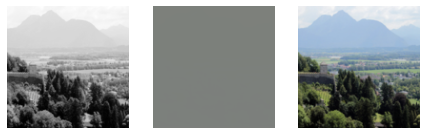

epoch 0: 0.0113851485948544
epoch 10: 0.004117520555155352
epoch 20: 0.0038004770322004333


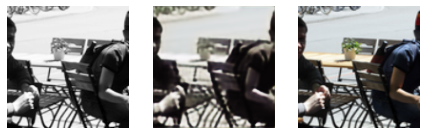

epoch 30: 0.003378889843588695
epoch 40: 0.0033092924422817305


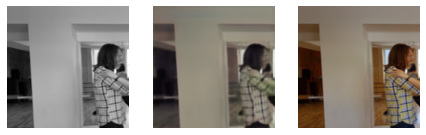

epoch 50: 0.003326284990180284
epoch 60: 0.0031006385252112523
epoch 70: 0.0029677723214263096


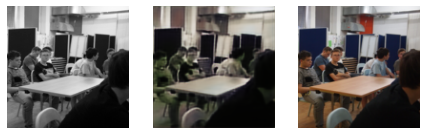

epoch 80: 0.0032739773305365816


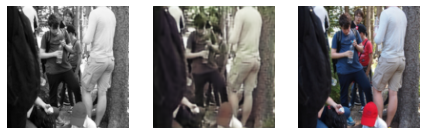

epoch 90: 0.002950685389805585


In [18]:
history = []
for epoch in range(num_epochs):
    sum_loss = 0
    i = 0
    for x, y in loader:
        model.train()

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        pred = model(x)
        loss = criterion(pred, y)
        sum_loss += loss.item()

        loss.backward()
        optimizer.step()

        model.eval()
        if (epoch in [0, 25, 50, 75, 90, 100]) and (i == 0):
            plot(x.cpu()[0], y.cpu()[0])
            i += 1

        del x
        del y
        torch.cuda.empty_cache()

    epoch_loss = sum_loss / len(loader)
    history.append(epoch_loss)
    if epoch % 10 == 0:
        print(f'epoch {epoch}: {sum_loss / len(loader)}')

# Test model

In [29]:
def test_plot(data):
    img_gray, img_true = data
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    plt.figure(figsize=(10,10))
    
    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    
    plt.show()

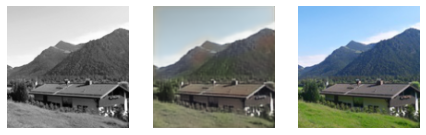

In [69]:
test_plot(dataset[362])

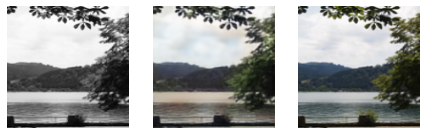

In [31]:
test_plot(dataset[139])

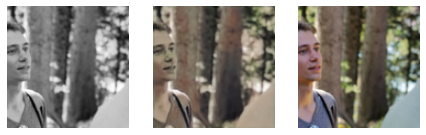

In [38]:
test_plot(dataset[197])

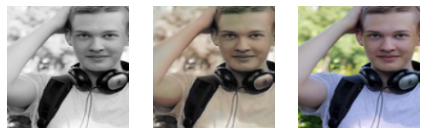

In [45]:
test_plot(dataset[261])

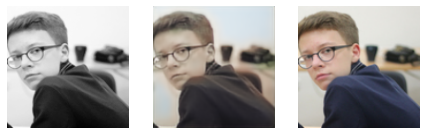

In [67]:
test_plot(dataset[367])

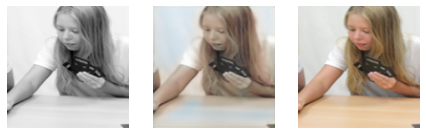

In [80]:
test_plot(dataset[375])

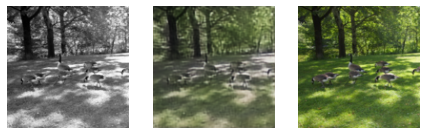

In [83]:
test_plot(dataset[707])